In [1]:
%matplotlib inline

In [2]:
pwd

'/Users/jeremymobley/Desktop/cbb_modeling/Python'

In [3]:
from helper_functions import *

In [4]:
cd /Users/jeremymobley/Desktop/cbb_modeling/data/2018/

/Users/jeremymobley/Desktop/cbb_modeling/data/2018


In [5]:
import scipy
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn import linear_model
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn import feature_selection
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

#### Load Data

In [6]:
teams = read_in_file_to_df("Teams")
tourney_compact_results = read_in_file_to_df("NCAATourneyCompactResults")
tourney_detailed_results = read_in_file_to_df("NCAATourneyDetailedResults")
reg_season_detailed_results = read_in_file_to_df("RegularSeasonDetailedResults")
reg_season_compact_results = read_in_file_to_df("RegularSeasonCompactResults")
sample_sub1 = read_in_file_to_df("SampleSubmissionStage1")
sample_sub2 = read_in_file_to_df("SampleSubmissionStage2")
seasons = read_in_file_to_df("Seasons")

Teams (364, 4)
NCAATourneyCompactResults (2117, 8)
NCAATourneyDetailedResults (981, 34)
RegularSeasonDetailedResults (82041, 34)
RegularSeasonCompactResults (156089, 8)
SampleSubmissionStage1 (9112, 2)
SampleSubmissionStage2 (2278, 2)
Seasons (34, 6)


#### Combine regular season and tourney detailed results

In [7]:
all_detailed_results = pd.concat([reg_season_detailed_results, tourney_detailed_results])
print(all_detailed_results.shape)

(83022, 34)


### Calculate Advanced Metrics

#### Add in possession features

In [8]:
all_detailed_results = create_poss_fields(all_detailed_results)
all_detailed_results = create_ppp_fields(all_detailed_results)

#### Add advanced metrics
Takes a few seconds...

In [9]:
all_detailed_results = add_advanced_metrics(all_detailed_results)

#### Add in date from DayNum

In [10]:
all_detailed_results = add_in_date(all_detailed_results, seasons)
print(all_detailed_results.shape)

(83022, 62)


#### Add in team names

In [11]:
all_detailed_results = add_in_team_names(all_detailed_results, teams)
print(all_detailed_results.shape)

(83022, 64)


In [12]:
# Add in score_diff field
all_detailed_results['score_diff'] = all_detailed_results['WScore'] - all_detailed_results['LScore']
print(all_detailed_results.shape)

(83022, 65)


## Create train data set

Train data set structure:  
* Result field is binary 0/1 representing if Team1 beats Team2
* Every game is represented by 2 different records

In [13]:
train = create_master_train(all_detailed_results)
print(train.shape)

(166044, 66)


In [14]:
# Create location variables
train['t1_Loc_H'] = [1 if loc=="H" else 0 for loc in train['t1_Loc']]
train['t1_Loc_N'] = [1 if loc=="N" else 0 for loc in train['t1_Loc']]

#### Add in Massey Ordinals

In [15]:
# Read in massey_ordinals file
massey_ordinals = read_in_file_to_df("MasseyOrdinals_thruSeason2018_Day128")
massey_ordinals_18 = read_in_file_to_df("MasseyOrdinals_2018_133_only_43Systems")
massey_ordinals.columns = ['Season', 'DayNum', 'SystemName', 'TeamID', 'OrdinalRank']
massey_ordinals_18.columns = ['Season', 'DayNum', 'SystemName', 'TeamID', 'OrdinalRank']
massey_ordinals = pd.concat([massey_ordinals, massey_ordinals_18])
print(massey_ordinals.shape)

MasseyOrdinals_thruSeason2018_Day128 (3470328, 5)
MasseyOrdinals_2018_133_only_43Systems (13854, 5)
(3484182, 5)


In [16]:
massey_rank_systems = ["WLK", "DOK", "POM", "MOR", "SAG", "WIL", "PGH", "NOL", "KPK", "MAS"]

In [17]:
for rnk_sys in massey_rank_systems:
    train = add_in_massey_ordinal_field(train, rnk_sys, massey_ordinals)

##### Look at Massey Ordinal data

In [374]:
# Look at most populated ranking systems
massey_ordinals[(massey_ordinals['DayNum']>50) & (massey_ordinals['Season']>2010)]['SystemName'].value_counts().head(10)

WLK    31043
DOK    31043
POM    31043
MOR    31043
SAG    31043
WIL    31042
PGH    31030
NOL    31011
KPK    30695
MAS    30695
Name: SystemName, dtype: int64

---

### Loop through train to create features

##### Dev process for one season

In [120]:
start_time = time.time()

# create 2017 df for dev
train_17 = train[train['Season']==2017].copy().reset_index(drop=True).sort_values(['DayNum'])
train_17['t1_off_ssn_avg_PPP'] = 0

# create team_metrics_dict to track ongoing metrics
team_metrics_dict = {tm_id: {'gp': 0, 't1_off_ssn_avg_PPP': 0} for tm_id in train['t1_TeamID'].unique()}

# loop through each record in train_17
for i, row in enumerate(train_17[['t1_TeamID', 't1_PPP']].itertuples(index=False), 1):

    if i % 1000 == 0 :
        print(i)

    t1 = row[0]
    t1_game_PPP = row[1]
    t1_gp = team_metrics_dict.get(t1).get('gp')
    t1_ssn_avg_PPP = team_metrics_dict.get(t1).get('t1_off_ssn_avg_PPP')
    
    # update train_17
    train_17.loc[i, 't1_off_ssn_avg_PPP'] = t1_ssn_avg_PPP
    
    # update team_metrics_dict
    team_metrics_dict[t1]['t1_off_ssn_avg_PPP'] = ((t1_ssn_avg_PPP * t1_gp) + t1_game_PPP)/ (t1_gp + 1.0)
    team_metrics_dict[t1]['gp'] += 1

# write out final season_totals for 2018 to use for test


print("Processing took " + str(int(round(time.time() - start_time))) + " seconds")

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
Processing took 4 seconds


In [118]:
print(train_17[train_17['t1_off_ssn_avg_PPP']==0].shape)
print(train_17[train_17['t1_off_ssn_avg_PPP']>0].shape)
print(train_17['t1_off_ssn_avg_PPP'].mean())

(351, 99)
(10573, 99)
0.9955991253743911


In [200]:
HTML(train_17[(train_17['t1_TeamID']==1207)].head().to_html())

,DayNum,NumOT,Result,Season,TotPoss,game_date,score_diff,t1_Ast,t1_AstR,t1_Blk,t1_DR,t1_DRP,t1_DefRtg,t1_FGA,t1_FGA3,t1_FGM,t1_FGM3,t1_FTA,t1_FTAR,t1_FTM,t1_Loc,t1_NetRtg,t1_OR,t1_ORP,t1_OffRtg,t1_PF,t1_PPP,t1_Poss,t1_RP,t1_Score,t1_Stl,t1_TO,t1_TOR,t1_TSP,t1_TeamID,t1_TeamName,t1_eFGP,t2_Ast,t2_AstR,t2_Blk,t2_DR,t2_DRP,t2_DefRtg,t2_FGA,t2_FGA3,t2_FGM,t2_FGM3,t2_FTA,t2_FTAR,t2_FTM,t2_NetRtg,t2_OR,t2_ORP,t2_OffRtg,t2_PF,t2_PPP,t2_Poss,t2_RP,t2_Score,t2_Stl,t2_TO,t2_TOR,t2_TSP,t2_TeamID,t2_TeamName,t2_eFGP,t1_Loc_H,t1_Loc_N,t1_WLK_rnk,t2_WLK_rnk,t1_WLK_rnk_diff,t1_DOK_rnk,t2_DOK_rnk,t1_DOK_rnk_diff,t1_POM_rnk,t2_POM_rnk,t1_POM_rnk_diff,t1_MOR_rnk,t2_MOR_rnk,t1_MOR_rnk_diff,t1_SAG_rnk,t2_SAG_rnk,t1_SAG_rnk_diff,t1_WIL_rnk,t2_WIL_rnk,t1_WIL_rnk_diff,t1_PGH_rnk,t2_PGH_rnk,t1_PGH_rnk_diff,t1_NOL_rnk,t2_NOL_rnk,t1_NOL_rnk_diff,t1_KPK_rnk,t2_KPK_rnk,t1_KPK_rnk_diff,t1_MAS_rnk,t2_MAS_rnk,t1_MAS_rnk_diff,t1_off_ssn_avg_PPP
268,12.0,0.0,1.0,2017.0,152.50,2016-11-12,45.0,22.0,20.936429,2.0,25.0,0.555556,39.344262,54.0,17.0,36.0,9.0,32.0,0.592593,24.0,H,0.000000,8.0,0.380952,68.852459,24.0,1.377049,76.20,0.500000,105.0,13.0,15.0,10.346125,77.115159,1207.0,Georgetown,0.750000,11.0,10.346125,2.0,13.0,0.619048,68.852459,57.0,25.0,21.0,6.0,28.0,0.491228,12.0,-29.508197,20.0,0.444444,39.344262,26.0,0.786885,76.30,0.318182,60.0,6.0,26.0,10.346125,43.277553,1367.0,SC Upstate,0.421053,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
489,15.0,0.0,0.0,2017.0,148.40,2016-11-15,-1.0,7.0,7.736516,4.0,24.0,0.727273,51.212938,50.0,15.0,16.0,6.0,42.0,0.840000,37.0,H,-0.673854,11.0,0.305556,50.539084,24.0,1.010782,73.95,0.478261,75.0,6.0,15.0,7.736516,54.760514,1207.0,Georgetown,0.380000,11.0,11.742101,7.0,25.0,0.694444,50.539084,58.0,27.0,26.0,7.0,22.0,0.379310,17.0,0.000000,9.0,0.272727,51.212938,32.0,1.024259,74.45,0.492754,76.0,6.0,15.0,7.736516,56.146572,1268.0,Maryland,0.508621,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.057143
661,17.0,0.0,0.0,2017.0,142.50,2016-11-17,-6.0,14.0,14.724443,3.0,18.0,0.642857,54.736842,56.0,20.0,23.0,3.0,32.0,0.571429,23.0,H,-4.210526,12.0,0.315789,50.526316,25.0,1.010526,70.20,0.424242,72.0,5.0,11.0,14.724443,51.369863,1207.0,Georgetown,0.437500,12.0,12.858980,2.0,26.0,0.684211,50.526316,51.0,12.0,28.0,6.0,28.0,0.549020,16.0,0.000000,10.0,0.357143,54.736842,29.0,1.094737,72.30,0.545455,78.0,3.0,18.0,14.724443,61.591914,1117.0,Arkansas St,0.607843,1.0,0.0,NaN,NaN,NaN,11.0,213.0,-202.0,25.0,276.0,-251.0,40.0,314.0,-274.0,28.0,257.0,-229.0,75.0,283.0,-208.0,81.0,292.0,-211.0,NaN,NaN,NaN,28.0,269.0,-241.0,41.0,260.0,-219.0,1.157120
1132,21.0,0.0,1.0,2017.0,141.95,2016-11-21,4.0,10.0,10.451505,10.0,26.0,0.619048,42.972878,61.0,21.0,21.0,6.0,22.0,0.360656,17.0,N,0.000000,14.0,0.318182,45.790771,21.0,0.915815,72.45,0.465116,65.0,8.0,15.0,10.548523,45.981890,1207.0,Georgetown,0.393443,10.0,10.548523,10.0,30.0,0.681818,45.790771,59.0,17.0,23.0,4.0,20.0,0.338983,11.0,-2.817894,16.0,0.380952,42.972878,22.0,0.859458,69.50,0.511628,61.0,7.0,17.0,10.548523,44.985251,1332.0,Oregon,0.423729,0.0,1.0,NaN,NaN,NaN,11.0,24.0,-13.0,25.0,9.0,16.0,40.0,9.0,31.0,28.0,25.0,3.0,75.0,7.0,68.0,81.0,8.0,73.0,NaN,NaN,NaN,28.0,18.0,10.0,41.0,12.0,29.0,1.058958
1224,22.0,0.0,0.0,2017.0,131.10,2016-11-22,-16.0,7.0,9.615385,1.0,20.0,0.500000,55.682685,47.0,15.0,18.0,5.0,20.0,0.425532,16.0,N,-12.204424,1.0,0.032258,43.478261,16.0,0.869565,65.50,0.563380,57.0,6.0,10.0,9.615385,51.075269,1207.0,Georgetown,0.436170,12.0,12.366035,5.0,30.0,0.967742,43.478261,65.0,22.0,28.0,5.0,16.0,0.246154,12.0,0.000000,20.0,0.500000,55.682685,18.0,1.113654,65.60,0.704225,73.0,5.0,13.0,9.615385,50.666297,1458.0,Wisconsin,0.469231,0.0,1.0,NaN,NaN,NaN,11.0,27.0,-16.0,25.0,8.0,17.0,40.0,10.0,30.0,28.0,4.0,24.0,75.0,35.0,40.0,81.0,33.0,48.0,NaN,NaN,NaN,28.0,31.0,-3.0,41.0,24.0,17.0,1.037599


#### Loop through all seasons

In [267]:
start_time = time.time()
all_seasons_train = pd.DataFrame()
for season_yr in train['Season'].unique():
    print(season_yr)
    
    # create subset train df of single season
    ssn_train = train[train['Season']==season_yr].copy().reset_index(drop=True).sort_values(['DayNum'])
    ssn_train['t1_ssn_avg_off_PPP'] = 0
    ssn_train['t1_ssn_avg_def_PPP'] = 0

    # create team_metrics_dict to track ongoing metrics
    team_metrics_dict = {tm_id: {'gp': 0, 
                                 'gp_ha_adj':0.0,
                                 't1_ssn_avg_off_PPP':0.0,
                                 't1_ssn_avg_def_PPP':0.0, 
                                 't1_ssn_avg_off_opp_adj_PPP':0.0,
                                 't1_ssn_avg_def_opp_adj_PPP':0.0, 
                                 't1_ssn_avg_off_ha_adj_PPP':0.0,
                                 't1_ssn_avg_def_ha_adj_PPP':0.0,
                                 't1_ssn_avg_opp_off_PPP':0.0,
                                 't1_ssn_avg_opp_def_PPP':0.0,
                                 't1_ssn_avg_opp_opp_off_PPP':0.0,
                                 't1_ssn_avg_opp_opp_def_PPP':0.0
                                } for tm_id in train['t1_TeamID'].unique()}
    
    t1_ssn_avg_off_PPP_list = []
    t1_ssn_avg_def_PPP_list = []
    t1_ssn_avg_off_opp_adj_PPP_list = []
    t1_ssn_avg_def_opp_adj_PPP_list = []
    t1_ssn_avg_off_ha_adj_PPP_list = []
    t1_ssn_avg_def_ha_adj_PPP_list = []
    t1_ssn_avg_opp_off_PPP_list = []
    t1_ssn_avg_opp_def_PPP_list = []
    t1_ssn_avg_opp_opp_off_PPP_list = []
    t1_ssn_avg_opp_opp_def_PPP_list = []
    # loop through each record in ssn_train
    for i, row in enumerate(ssn_train[['t1_TeamID', 't2_TeamID', 't1_PPP', 't2_PPP', 'DayNum', 't1_Loc']].itertuples(index=False)):

        t1 = row[0]
        t2 = row[1]
        t1_off_PPP = row[2]
        t1_def_PPP = row[3]
        daynum = row[4]
        t1_loc = row[5]
        t1_gp = team_metrics_dict.get(t1).get('gp')
        t1_gp_ha_adj = team_metrics_dict.get(t1).get('gp_ha_adj')
        t1_ssn_avg_off_PPP = team_metrics_dict.get(t1).get('t1_ssn_avg_off_PPP')
        t1_ssn_avg_def_PPP = team_metrics_dict.get(t1).get('t1_ssn_avg_def_PPP')
        t2_ssn_avg_off_PPP = team_metrics_dict.get(t2).get('t1_ssn_avg_off_PPP')
        t2_ssn_avg_def_PPP = team_metrics_dict.get(t2).get('t1_ssn_avg_def_PPP')
        t1_ssn_avg_off_opp_adj_PPP = team_metrics_dict.get(t1).get('t1_ssn_avg_off_opp_adj_PPP')
        t1_ssn_avg_def_opp_adj_PPP = team_metrics_dict.get(t1).get('t1_ssn_avg_def_opp_adj_PPP')
        t1_ssn_avg_off_ha_adj_PPP = team_metrics_dict.get(t1).get('t1_ssn_avg_off_ha_adj_PPP')
        t1_ssn_avg_def_ha_adj_PPP = team_metrics_dict.get(t1).get('t1_ssn_avg_def_ha_adj_PPP')
        t1_ssn_avg_opp_off_PPP = team_metrics_dict.get(t2).get('t1_ssn_avg_off_PPP')
        t1_ssn_avg_opp_def_PPP = team_metrics_dict.get(t2).get('t1_ssn_avg_def_PPP')
        t1_ssn_avg_opp_opp_off_PPP = team_metrics_dict.get(t1).get('t1_ssn_avg_opp_opp_off_PPP')
        t1_ssn_avg_opp_opp_def_PPP = team_metrics_dict.get(t1).get('t1_ssn_avg_opp_opp_def_PPP')
        t2_ssn_avg_opp_off_PPP = team_metrics_dict.get(t2).get('t1_ssn_avg_opp_off_PPP')
        t2_ssn_avg_opp_def_PPP = team_metrics_dict.get(t2).get('t1_ssn_avg_opp_def_PPP')


        t1_ssn_avg_off_PPP_list.append(t1_ssn_avg_off_PPP)
        t1_ssn_avg_def_PPP_list.append(t1_ssn_avg_def_PPP)
        t1_ssn_avg_off_opp_adj_PPP_list.append(t1_ssn_avg_off_opp_adj_PPP)
        t1_ssn_avg_def_opp_adj_PPP_list.append(t1_ssn_avg_def_opp_adj_PPP)
        t1_ssn_avg_off_ha_adj_PPP_list.append(t1_ssn_avg_off_ha_adj_PPP)
        t1_ssn_avg_def_ha_adj_PPP_list.append(t1_ssn_avg_def_ha_adj_PPP)
        t1_ssn_avg_opp_off_PPP_list.append(t1_ssn_avg_opp_off_PPP)
        t1_ssn_avg_opp_def_PPP_list.append(t1_ssn_avg_opp_def_PPP)
        t1_ssn_avg_opp_opp_off_PPP_list.append(t1_ssn_avg_opp_opp_off_PPP)
        t1_ssn_avg_opp_opp_def_PPP_list.append(t1_ssn_avg_opp_opp_def_PPP)
        
        if t1_loc=="H":
            loc_weight = 0.6
        else:
            loc_weight = 1.0
        
        # update team_metrics_dict, only for regular season games
        if daynum <= 132:
            team_metrics_dict[t1]['t1_ssn_avg_off_PPP'] = ((t1_ssn_avg_off_PPP * t1_gp) + t1_off_PPP)/ (t1_gp + 1.0)
            team_metrics_dict[t1]['t1_ssn_avg_def_PPP'] = ((t1_ssn_avg_def_PPP * t1_gp) + t1_def_PPP)/ (t1_gp + 1.0)
            team_metrics_dict[t1]['t1_ssn_avg_off_opp_adj_PPP'] = ((t1_ssn_avg_off_opp_adj_PPP * t1_gp_ha_adj) + ((t1_off_PPP - t2_ssn_avg_def_PPP) * loc_weight)) / (t1_gp_ha_adj + loc_weight)
            team_metrics_dict[t1]['t1_ssn_avg_def_opp_adj_PPP'] = ((t1_ssn_avg_def_opp_adj_PPP * t1_gp_ha_adj) + ((t2_ssn_avg_off_PPP - t1_def_PPP) * loc_weight)) / (t1_gp_ha_adj + loc_weight)
            team_metrics_dict[t1]['t1_ssn_avg_off_ha_adj_PPP'] = ((t1_ssn_avg_off_ha_adj_PPP * t1_gp_ha_adj) + (t1_off_PPP * loc_weight))/ (t1_gp_ha_adj + loc_weight)
            team_metrics_dict[t1]['t1_ssn_avg_def_ha_adj_PPP'] = ((t1_ssn_avg_def_ha_adj_PPP * t1_gp_ha_adj) + (t1_def_PPP * loc_weight))/ (t1_gp_ha_adj + loc_weight)
            team_metrics_dict[t1]['t1_ssn_avg_opp_off_PPP'] = ((t1_ssn_avg_opp_off_PPP * t1_gp) + t1_def_PPP)/ (t1_gp + 1.0)
            team_metrics_dict[t1]['t1_ssn_avg_opp_def_PPP'] = ((t1_ssn_avg_opp_def_PPP * t1_gp) + t1_off_PPP)/ (t1_gp + 1.0)
            team_metrics_dict[t1]['t1_ssn_avg_opp_opp_off_PPP'] = ((t1_ssn_avg_opp_opp_off_PPP * t1_gp) + t2_ssn_avg_opp_off_PPP)/ (t1_gp + 1.0)
            team_metrics_dict[t1]['t1_ssn_avg_opp_opp_def_PPP'] = ((t1_ssn_avg_opp_opp_def_PPP * t1_gp) + t2_ssn_avg_opp_def_PPP)/ (t1_gp + 1.0)
            team_metrics_dict[t1]['gp'] += 1
            team_metrics_dict[t1]['gp_ha_adj'] += loc_weight
    
    # update ssn_train with lists
    ssn_train['t1_ssn_avg_off_PPP'] = t1_ssn_avg_off_PPP_list
    ssn_train['t1_ssn_avg_def_PPP'] = t1_ssn_avg_def_PPP_list
    ssn_train['t1_ssn_avg_off_opp_adj_PPP'] = t1_ssn_avg_off_opp_adj_PPP_list
    ssn_train['t1_ssn_avg_def_opp_adj_PPP'] = t1_ssn_avg_def_opp_adj_PPP_list
    ssn_train['t1_ssn_avg_off_ha_adj_PPP'] = t1_ssn_avg_off_ha_adj_PPP_list
    ssn_train['t1_ssn_avg_def_ha_adj_PPP'] = t1_ssn_avg_def_ha_adj_PPP_list
    ssn_train['t1_ssn_avg_opp_off_PPP'] = t1_ssn_avg_opp_off_PPP_list
    ssn_train['t1_ssn_avg_opp_def_PPP'] = t1_ssn_avg_opp_def_PPP_list
    ssn_train['t1_ssn_avg_opp_opp_off_PPP'] = t1_ssn_avg_opp_opp_off_PPP_list
    ssn_train['t1_ssn_avg_opp_opp_def_PPP'] = t1_ssn_avg_opp_opp_def_PPP_list
    
    # combine season train back into full training data set
    all_seasons_train = pd.concat([all_seasons_train, ssn_train])

    # write out final season_totals for 2018 to use for test
    if season_yr==2018:
        team_metrics_df_18 = pd.DataFrame.from_dict(team_metrics_dict, orient='index').reset_index().rename(columns={"index":"t1_TeamID"})
        team_metrics_df_18.to_csv("team_metrics_df_18.csv")


print(all_seasons_train.shape)
print("Processing took " + str(int(round(time.time() - start_time))) + " seconds")

2008
2013
2014
2011
2012
2010
2009
2006
2007
2005
2003
2004
2017
2016
2018
2015
(166044, 108)
Processing took 6 seconds


## Look at all train records

In [269]:
HTML(all_seasons_train[(all_seasons_train['Season']==2007) & (all_seasons_train['t1_TeamID']==1207)].sort_values('DayNum').to_html())

,DayNum,NumOT,Result,Season,TotPoss,game_date,score_diff,t1_Ast,t1_AstR,t1_Blk,t1_DR,t1_DRP,t1_DefRtg,t1_FGA,t1_FGA3,t1_FGM,t1_FGM3,t1_FTA,t1_FTAR,t1_FTM,t1_Loc,t1_NetRtg,t1_OR,t1_ORP,t1_OffRtg,t1_PF,t1_PPP,t1_Poss,t1_RP,t1_Score,t1_Stl,t1_TO,t1_TOR,t1_TSP,t1_TeamID,t1_TeamName,t1_eFGP,t2_Ast,t2_AstR,t2_Blk,t2_DR,t2_DRP,t2_DefRtg,t2_FGA,t2_FGA3,t2_FGM,t2_FGM3,t2_FTA,t2_FTAR,t2_FTM,t2_NetRtg,t2_OR,t2_ORP,t2_OffRtg,t2_PF,t2_PPP,t2_Poss,t2_RP,t2_Score,t2_Stl,t2_TO,t2_TOR,t2_TSP,t2_TeamID,t2_TeamName,t2_eFGP,t1_Loc_H,t1_Loc_N,t1_WLK_rnk,t2_WLK_rnk,t1_WLK_rnk_diff,t1_DOK_rnk,t2_DOK_rnk,t1_DOK_rnk_diff,t1_POM_rnk,t2_POM_rnk,t1_POM_rnk_diff,t1_MOR_rnk,t2_MOR_rnk,t1_MOR_rnk_diff,t1_SAG_rnk,t2_SAG_rnk,t1_SAG_rnk_diff,t1_WIL_rnk,t2_WIL_rnk,t1_WIL_rnk_diff,t1_PGH_rnk,t2_PGH_rnk,t1_PGH_rnk_diff,t1_NOL_rnk,t2_NOL_rnk,t1_NOL_rnk_diff,t1_KPK_rnk,t2_KPK_rnk,t1_KPK_rnk_diff,t1_MAS_rnk,t2_MAS_rnk,t1_MAS_rnk_diff,t1_ssn_avg_off_PPP,t1_ssn_avg_def_PPP,t1_ssn_avg_off_opp_adj_PPP,t1_ssn_avg_def_opp_adj_PPP,t1_ssn_avg_off_ha_adj_PPP,t1_ssn_avg_def_ha_adj_PPP,t1_ssn_avg_opp_off_PPP,t1_ssn_avg_opp_def_PPP,t1_ssn_avg_opp_opp_off_PPP,t1_ssn_avg_opp_opp_def_PPP
211,12,0,1.0,2007,128.625,2006-11-11,10.0,9,10.643330,5,26,0.896552,45.869776,53,23,22,6,24,0.452830,19,H,0.000000,13,0.393939,53.644315,15,1.072886,63.400,0.629032,69,3,12,17.106549,54.279421,1207,Georgetown,0.471698,14,17.106549,1,20,0.606061,53.644315,49,26,22,9,11,0.224490,6,-7.774538,3,0.103448,45.869776,19,0.917396,65.225,0.532258,59,10,14,17.106549,54.791976,1216,Hartford,0.540816,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.917396,1.072886,0.000000,0.000000
568,16,0,1.0,2007,145.600,2006-11-15,16.0,15,14.869151,5,25,0.735294,48.076923,61,12,32,4,27,0.442623,18,A,0.000000,13,0.351351,59.065934,25,1.181319,73.825,0.535211,86,6,13,14.014661,59.001098,1207,Georgetown,0.557377,13,14.014661,5,24,0.648649,59.065934,53,21,22,5,29,0.547170,21,-10.989011,9,0.264706,48.076923,21,0.961538,71.775,0.521127,70,4,14,14.014661,53.223844,1435,Vanderbilt,0.462264,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.072886,0.917396,0.000000,0.000000,1.072886,0.917396,0.000000,0.000000,1.072886,0.917396
860,20,0,0.0,2007,121.000,2006-11-19,-13.0,13,16.041461,6,21,0.583333,61.983471,47,19,23,6,16,0.340426,10,H,-10.743802,7,0.259259,51.239669,19,1.024793,61.600,0.571429,62,4,14,16.041461,57.364915,1207,Georgetown,0.553191,16,17.865118,1,20,0.740741,51.239669,56,16,24,9,24,0.428571,18,0.000000,15,0.416667,61.983471,19,1.239669,59.400,0.555556,75,8,7,16.041461,56.340144,1330,Old Dominion,0.508929,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.127102,0.939467,0.738324,-0.600962,1.140657,0.944985,1.011183,0.880536,0.536443,0.458698
1172,23,0,1.0,2007,115.850,2006-11-22,13.0,12,15.166835,6,14,0.583333,51.791109,43,19,24,8,23,0.534884,17,A,0.000000,10,0.434783,63.012516,20,1.260250,57.925,0.510638,73,6,14,15.166835,68.712349,1207,Georgetown,0.651163,12,15.166835,1,13,0.565217,63.012516,41,7,20,2,23,0.560976,18,-11.221407,10,0.416667,51.791109,19,1.035822,57.925,0.489362,60,6,16,15.166835,58.685446,1193,Fairfield,0.512195,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.092999,1.039534,0.576306,-0.499377,1.109057,1.025353,0.856309,0.994144,0.639737,0.697254
1527,28,0,1.0,2007,124.200,2006-11-27,15.0,20,22.104332,7,23,0.741935,43.478261,48,15,25,7,17,0.354167,12,H,0.000000,8,0.320000,55.555556,13,1.111111,63.075,0.553571,69,6,15,12.722646,62.184571,1207,Georgetown,0.593750,10,12.722646,2,17,0.680000,55.555556,50,9,21,5,15,0.300000,7,-12.077295,8,0.258065,43.478261,16,0.869565,61.125,0.446429,54,11,12,12.722646,47.703180,1123,Ball St,0.470000,1,0,NaN,NaN,NaN,NaN,N

---

# Modeling

### Create modeling df

In [292]:
all_modeling_fields = [    
    "t1_SAG_rnk", "t2_SAG_rnk", 
    "t1_MAS_rnk", "t2_MAS_rnk", 
    "t1_WLK_rnk", "t2_WLK_rnk", 
    "t1_DOK_rnk", "t2_DOK_rnk", 
    "t1_POM_rnk", "t2_POM_rnk", 
    "t1_MOR_rnk", "t2_MOR_rnk", 
    "t1_WIL_rnk", "t2_WIL_rnk", 
    "t1_PGH_rnk", "t2_PGH_rnk", 
    "t1_MAS_rnk_diff",
    "t1_WLK_rnk_diff",
    "t1_DOK_rnk_diff",
    "t1_POM_rnk_diff",
    "t1_MOR_rnk_diff",
    "t1_SAG_rnk_diff",
    "t1_WIL_rnk_diff",
    "t1_PGH_rnk_diff",
    #"t1_ssn_avg_off_PPP", "t1_ssn_avg_def_PPP",
    "t1_ssn_avg_off_ha_adj_PPP",
    "t1_ssn_avg_def_ha_adj_PPP",
    "t1_ssn_avg_off_opp_adj_PPP",
    "t1_ssn_avg_def_opp_adj_PPP",
    "t1_ssn_avg_opp_off_PPP", "t1_ssn_avg_opp_def_PPP", 
    "t1_ssn_avg_opp_opp_off_PPP", "t1_ssn_avg_opp_opp_def_PPP",
    "t1_Loc_H",
    "t1_Loc_N"
]

In [293]:
model_train_df = all_seasons_train.copy()
print(model_train_df.shape)
model_train_df = model_train_df[model_train_df['DayNum'] > 100]
model_train_df = model_train_df[model_train_df['DayNum'] <= 132]
model_train_df = model_train_df.dropna(subset=all_modeling_fields)
print(model_train_df.shape)

(166044, 108)
(24838, 108)


### Create test games df

In [272]:
model_test_df = all_seasons_train.copy()
model_test_df = model_test_df[model_test_df['DayNum'] > 132]
model_test_df = model_test_df.dropna(subset=all_modeling_fields)
print(model_test_df.shape)

(1066, 108)


### Create final 2018 training data set

In [294]:
model_train_df = model_train_df[model_train_df['Season'] <= 2018]
model_train_df = model_train_df[model_train_df['DayNum'] > 110]
model_train_df = model_train_df[(model_train_df['DayNum'] <= 132) | (model_train_df['DayNum'] != 2018)]
model_train_df = model_train_df.dropna(subset=gbm_model_fields)

### Logistic

In [25]:
logistic = linear_model.LogisticRegression()

In [26]:
#logistic_model_fields = ['t1_SAG_rnk', 't2_SAG_rnk', "t1_MAS_rnk", "t2_MAS_rnk", "t1_Loc_H"]
#logistic_model_fields = ['t1_SAG_rnk_diff', "t1_MAS_rnk", "t2_MAS_rnk", "t1_Loc_H"]
#logistic_model_fields = ['t1_SAG_rnk', 't2_SAG_rnk', "t1_MAS_rnk", "t2_MAS_rnk"]
#logistic_model_fields = ['t1_SAG_rnk_diff', "t1_MAS_rnk", "t2_MAS_rnk"]
#logistic_model_fields = ["t1_ssn_avg_off_PPP", "t1_ssn_avg_def_PPP",'t1_SAG_rnk_diff', "t1_MAS_rnk", "t2_MAS_rnk"]
logistic_model_fields = ["t1_ssn_avg_off_PPP", "t1_ssn_avg_def_PPP", 
                         "t1_ssn_avg_opp_off_PPP", "t1_ssn_avg_opp_def_PPP", 
                         "t1_ssn_avg_opp_opp_off_PPP", "t1_ssn_avg_opp_opp_def_PPP",
                         't1_SAG_rnk_diff', "t1_MAS_rnk", "t2_MAS_rnk"]

In [27]:
# Fit model
logistic.fit(model_train_df[logistic_model_fields], 
             model_train_df['Result'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
# Create preds
log_preds = logistic.predict_proba(model_test_df[logistic_model_fields])[:, 1]
print(calc_logloss(log_preds, model_test_df['Result']))

0.5918636995329708


### GBM

In [295]:
gbm_model_fields = [
    "t1_SAG_rnk", "t2_SAG_rnk", 
    "t1_MAS_rnk", "t2_MAS_rnk", 
    "t1_WLK_rnk", "t2_WLK_rnk", 
    "t1_DOK_rnk", "t2_DOK_rnk", 
    "t1_POM_rnk", "t2_POM_rnk", 
    "t1_MOR_rnk", "t2_MOR_rnk", 
    "t1_WIL_rnk", "t2_WIL_rnk", 
    "t1_MAS_rnk_diff",
    "t1_WLK_rnk_diff",
    "t1_DOK_rnk_diff",
    "t1_POM_rnk_diff",
    "t1_MOR_rnk_diff",
    "t1_SAG_rnk_diff",
    "t1_WIL_rnk_diff",
    #"t1_ssn_avg_off_PPP", "t1_ssn_avg_def_PPP",
    "t1_ssn_avg_off_ha_adj_PPP", 
    "t1_ssn_avg_def_ha_adj_PPP",
    "t1_ssn_avg_off_opp_adj_PPP",
    "t1_ssn_avg_def_opp_adj_PPP",
    "t1_ssn_avg_opp_off_PPP", "t1_ssn_avg_opp_def_PPP", 
    "t1_ssn_avg_opp_opp_off_PPP", "t1_ssn_avg_opp_opp_def_PPP",
    "t1_Loc_H",
    "t1_Loc_N"
]
#["NOL", "KPK", "MAS"]

In [296]:
gbm_class = GradientBoostingClassifier(n_estimators=80, 
                                max_depth=3, 
                                 max_features=6,
                                learning_rate=0.12)

In [297]:
gbm_class.fit(model_train_df[gbm_model_fields], model_train_df['Result'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.12, loss='deviance', max_depth=3,
              max_features=6, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=80,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [276]:
# create preds
gbm_preds = gbm_class.predict_proba(model_test_df[gbm_model_fields])[:, 1]
print(calc_logloss(gbm_preds, model_test_df['Result']))

0.5604020121139907


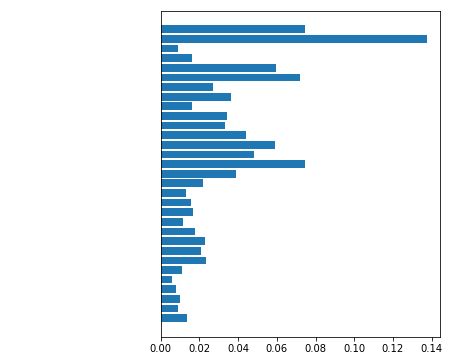

In [277]:
# Feature Importances
importances = gbm_class.feature_importances_
fig, ax = plt.subplots(figsize=(5, 6))
ax.barh(range(len(importances)), importances)
ax.tick_params(axis='y', colors='white', labelsize=10)
ax.set_yticklabels(gbm_model_fields)
plt.yticks(range(len(importances)), gbm_model_fields)
plt.show()

#### Tune GBM parameters

In [278]:
param_grid = {
        'n_estimators': [60,80,100],
        'max_depth': [3,4,5],
        'max_features': [5,6,7],
        'learning_rate': [0.08, 0.10, 0.12]
    }

gbm_class = GradientBoostingClassifier(random_state=0)

estimator = GridSearchCV(gbm_class,
                         param_grid, 
                         scoring='neg_log_loss',
                         n_jobs=-1)

In [279]:
# fit model
estimator.fit(model_train_df[gbm_model_fields], model_train_df['Result'])

GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [60, 80, 100], 'max_depth': [3, 4, 5], 'max_features': [5, 6, 7], 'learning_rate': [0.08, 0.1, 0.12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [280]:
gbm_preds = estimator.predict_proba(model_test_df[gbm_model_fields])[:, 1]
print(calc_logloss(gbm_preds, model_test_df['Result']))

0.5608316339595777


In [281]:
# Look at best parameter set
print(estimator.best_params_)
print(estimator.best_score_)
#print(estimator.cv_results_)

{'learning_rate': 0.08, 'max_depth': 4, 'max_features': 6, 'n_estimators': 100}
-0.5465222936224803


### Feature Selection

In [282]:
importances = feature_selection.f_classif(model_train_df[all_modeling_fields], model_train_df['Result'])

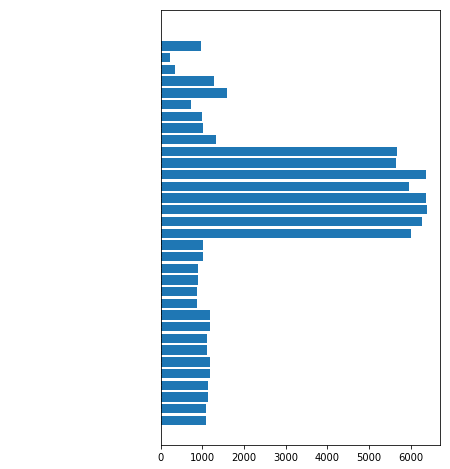

In [283]:
fig, ax = plt.subplots(figsize=(5, 8))
ax.barh(range(len(importances[0])), importances[0])
ax.tick_params(axis='y', colors='white', labelsize=10)
ax.set_yticklabels(all_modeling_fields)
plt.yticks(range(len(importances[0])), all_modeling_fields)
plt.show()

## Modeling - predict point spread
* Predict point spread directly -> convert to win probability
* Predict possessions, ppp -> convert to final score -> convert to win probability

In [298]:
gbm_ps = GradientBoostingRegressor(n_estimators=150, 
                                max_depth=4, 
                                 max_features=5,
                                learning_rate=0.06)

In [299]:
gbm_ps.fit(model_train_df[gbm_model_fields], model_train_df['score_diff'])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.06, loss='ls', max_depth=4, max_features=5,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=150, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [286]:
# create preds
ps_preds = gbm_ps.predict(model_test_df[gbm_model_fields])
gbm_ps_preds = np.array([scipy.stats.norm(0,10.5).cdf(pred) for pred in ps_preds])

In [287]:
print(calc_logloss(gbm_ps_preds, model_test_df['Result']))

0.5602274067281258


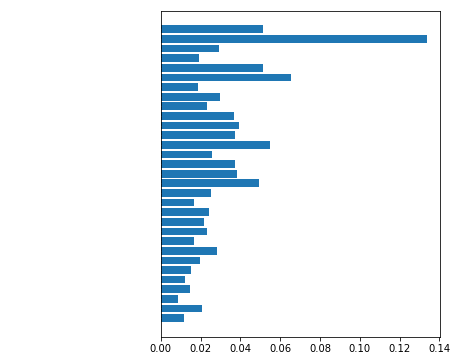

In [288]:
# Feature Importances
importances = gbm_ps.feature_importances_
fig, ax = plt.subplots(figsize=(5, 6))
ax.barh(range(len(importances)), importances)
ax.tick_params(axis='y', colors='white', labelsize=10)
ax.set_yticklabels(gbm_model_fields)
plt.yticks(range(len(importances)), gbm_model_fields)
plt.show()

In [289]:
param_grid = {
        'n_estimators': [80,100,150],
        'max_depth': [3,4,5,6],
        'max_features': [3,4,5],
        'learning_rate': [0.06, 0.08, 0.10]
    }

gbm_ps = GradientBoostingRegressor(random_state=0)

estimator = GridSearchCV(gbm_ps,
                         param_grid, 
                         scoring='neg_mean_squared_error',
                         n_jobs=-1)

In [290]:
# fit model
estimator.fit(model_train_df[gbm_model_fields], model_train_df['score_diff'])

# Look at best parameter set
print(estimator.best_params_)
print(estimator.best_score_)

# create preds
gbm_ps_preds = estimator.predict(model_test_df[gbm_model_fields])
gbm_ps_preds = np.array([scipy.stats.norm(0,10.5).cdf(pred) for pred in gbm_ps_preds])
print(calc_logloss(gbm_ps_preds, model_test_df['Result']))

{'learning_rate': 0.06, 'max_depth': 4, 'max_features': 5, 'n_estimators': 150}
-111.4172908976763
0.5581283168829866


---

## Create 2018 preds

##### Create test data set

In [300]:
test = sample_sub2.copy()

In [301]:
test['t1_TeamID'] = [int(x[5:9]) for x in test['ID']]
test['t2_TeamID'] = [int(x[10:14]) for x in test['ID']]
test['DayNum'] = 135
test['Season'] = 2018
# Create location variables
test['t1_Loc_H'] = 0
test['t1_Loc_N'] = 1
print(test.shape)

(2278, 8)


In [302]:
for rnk_sys in massey_rank_systems:
    test = add_in_massey_ordinal_field(test, rnk_sys, massey_ordinals)

#### Read in 2018 final team metrics

In [303]:
team_metrics_df_18 = read_in_file_to_df("team_metrics_df_18")

team_metrics_df_18 (355, 14)


In [304]:
test = pd.merge(left=test, 
                right=team_metrics_df_18, 
                left_on='t1_TeamID', 
                right_on='t1_TeamID')
print(test.shape)

(2278, 51)


In [305]:
test.head()

,ID,Pred,t1_TeamID,t2_TeamID,DayNum,Season,t1_Loc_H,t1_Loc_N,t1_WLK_rnk,t2_WLK_rnk,...,t1_ssn_avg_off_PPP,t1_ssn_avg_def_PPP,t1_ssn_avg_off_opp_adj_PPP,t1_ssn_avg_def_opp_adj_PPP,t1_ssn_avg_off_ha_adj_PPP,t1_ssn_avg_def_ha_adj_PPP,t1_ssn_avg_opp_off_PPP,t1_ssn_avg_opp_def_PPP,t1_ssn_avg_opp_opp_off_PPP,t1_ssn_avg_opp_opp_def_PPP
0,2018_1104_1112,0.5,1104,1112,135,2018,0,1,45,19,...,1.027758,0.997099,0.068328,0.040509,1.022882,1.010645,1.091211,1.000791,1.032365,0.969983
1,2018_1104_1305,0.5,1104,1305,135,2018,0,1,45,24,...,1.027758,0.997099,0.068328,0.040509,1.022882,1.010645,1.091211,1.000791,1.032365,0.969983
2,2018_1104_1116,0.5,1104,1116,135,2018,0,1,45,25,...,1.027758,0.997099,0.068328,0.040509,1.022882,1.010645,1.091211,1.000791,1.032365,0.969983
3,2018_1104_1120,0.5,1104,1120,135,2018,0,1,45,14,...,1.027758,0.997099,0.068328,0.040509,1.022882,1.010645,1.091211,1.000791,1.032365,0.969983
4,2018_1104_1137,0.5,1104,1137,135,2018,0,1,45,94,...,1.027758,0.997099,0.068328,0.040509,1.022882,1.010645,1.091211,1.000791,1.032365,0.969983


#### Create test preds

In [306]:
#test_log_preds = logistic.predict_proba(test[logistic_model_fields])[:, 1]
test_gbm_preds = gbm_class.predict_proba(test[gbm_model_fields])[:, 1]
test_ps_preds = gbm_ps.predict(test[gbm_model_fields])
test_gbm_ps_preds = np.array([scipy.stats.norm(0,10.5).cdf(pred) for pred in test_ps_preds])
avg_preds = (test_ps_preds + test_gbm_preds)/3.0

## Check preds

In [307]:
my_preds_df = pd.DataFrame()
my_preds_df['ID'] = test['ID']
my_preds_df['log_preds'] = test_log_preds
my_preds_df['gbm_preds'] = test_gbm_preds
my_preds_df['gbm_ps_preds'] = test_gbm_ps_preds
my_preds_df['ps_preds'] = -1 * test_ps_preds
print(my_preds_df.shape)

(2278, 5)


In [308]:
first_round_games = read_in_file_to_df("first_round_games")

first_round_games (32, 5)


In [309]:
def calc_vegas_line_preds(row):
    if row['vegas_line'] >= 0:
        return abs(scipy.stats.norm(0,10.5).cdf(row['vegas_line']) - 1)
    else:
        return 1 - scipy.stats.norm(0,10.5).cdf(row['vegas_line'])

In [310]:
first_round_games['vegas_line_preds'] = first_round_games.apply(calc_vegas_line_preds, axis=1)

In [311]:
# Add in first round games info
my_preds_df = pd.merge(left=my_preds_df, right=first_round_games, on='ID', how='left')
print(my_preds_df.shape)

(2278, 10)


In [319]:
def calc_my_final_pred(row):
    if row['pred_538'] >= 0:
        return (row['pred_538'] * 0.8) + (row['vegas_line_preds'] * 0.15) + (((row['gbm_ps_preds'] + row['gbm_preds']) / 2.0) * 0.05)
    else:
        return ((row['gbm_ps_preds'] * 0.9) + (row['gbm_preds'] * 0.1))

In [320]:
my_preds_df['final_pred'] = my_preds_df.apply(calc_my_final_pred, axis=1)

In [321]:
check_my_preds = my_preds_df[pd.notnull(my_preds_df['t1_name'])]

In [323]:
check_my_preds[['ID', 't1_name', 't2_name', 'pred_538', 'vegas_line_preds', 
                #'log_preds', 
                #'gbm_preds', 'gbm_ps_preds', 
                'final_pred',
                'ps_preds','vegas_line']].round(2).sort_values('pred_538')

,ID,t1_name,t2_name,pred_538,vegas_line_preds,final_pred,ps_preds,vegas_line
2121,2018_1347_1437,Radford,Villanova,0.01,0.01,0.01,27.61,23.5
2269,2018_1420_1438,UMBC,Virginia,0.02,0.01,0.02,24.05,23.0
1796,2018_1300_1462,TX Southern,Xavier,0.02,0.01,0.02,20.61,23.5
810,2018_1168_1345,CSU Fullerton,Purdue,0.02,0.03,0.03,15.00,20.5
1377,2018_1252_1314,Lipscomb,UNC,0.04,0.03,0.04,13.75,19.5
436,2018_1137_1277,Bucknell,MSU,0.08,0.08,0.09,7.84,14.5
1560,2018_1267_1455,Marshall,Wichita St.,0.09,0.14,0.10,11.48,11.5
2190,2018_1372_1403,SF Austin,Texas Tech,0.11,0.14,0.12,9.23,11.5
1477,2018_1293_1452,Murray St.,WVU,0.16,0.14,0.16,5.91,11.5
943,2018_1172_1246,Davidson,Kentucky,0.24,0.28,0.25,5.34,6.0


In [101]:
print(check_my_preds['pred_538'].corr(check_my_preds['vegas_line_preds']))

print(check_my_preds['pred_538'].corr(check_my_preds['gbm_ps_preds']))
print(check_my_preds['vegas_line_preds'].corr(check_my_preds['gbm_ps_preds']))

print(check_my_preds['pred_538'].corr(check_my_preds['gbm_preds']))
print(check_my_preds['vegas_line_preds'].corr(check_my_preds['gbm_preds']))

print(check_my_preds['vegas_line'].corr(check_my_preds['ps_preds']))


0.9884053410390415
0.976832787840598
0.9865940400922177
0.9674130669933129
0.9818161699888028
0.9781262526099204


In [343]:
check_my_preds[['t1_name', 't2_name', 'pred_538', 'vegas_line_preds', 
                'final_pred',
                'ps_preds','vegas_line']].round(2).sort_values('pred_538') \
    .rename(columns={'final_pred': 'JPM_pred',
                     'ps_preds':'JPM_spread_preds'}) \
    .to_csv('first_round_preds_JPM.csv', index=False)

---

### Create submission file

In [334]:
submission_df = pd.DataFrame()
submission_df['ID'] = my_preds_df['ID']
submission_df['Pred'] = my_preds_df['final_pred']
print(submission_df.shape)

(2278, 2)


In [325]:
pwd

'/Users/jeremymobley/Desktop/cbb_modeling/data/2018'

In [335]:
submission_df.to_csv("submission_3.csv", index=False)

In [338]:
sum(submission_df['Pred'])

1131.5999015888422

In [337]:
# manually adjust games

# S Dakota St.
submission_df.loc[submission_df['ID']=="2018_1326_1355",'Pred'] = 0.2

# NM St.
submission_df.loc[submission_df['ID']=="2018_1155_1308",'Pred'] = 0.2

In [339]:
submission_df.to_csv("submission_4.csv", index=False)

### Loop through years to create models including past tourney games

In [318]:
all_loglosses = []
for loop_season in range(2014,2018):
    print(loop_season)

    # create training data set
    model_train_df = model_train_df[model_train_df['Season'] <= loop_season]
    model_train_df = model_train_df[model_train_df['DayNum'] > 110]
    model_train_df = model_train_df[(model_train_df['DayNum'] <= 132) | (model_train_df['DayNum'] != loop_season)]
    model_train_df = model_train_df.dropna(subset=gbm_model_fields)

    # create test data set
    model_test_df = all_seasons_train.copy()
    model_test_df = model_test_df[model_test_df['Season'] == loop_season]
    model_test_df = model_test_df[model_test_df['DayNum'] > 132]
    model_test_df = model_test_df.dropna(subset=gbm_model_fields)
    
    # create model
    gbm_class = GradientBoostingClassifier(n_estimators=80, max_depth=4, max_features=6, learning_rate=0.08)
    gbm_class.fit(model_train_df[gbm_model_fields], model_train_df['Result'])
    gbm_ps = GradientBoostingRegressor(n_estimators=100, max_depth=4, max_features=4,learning_rate=0.08)
    gbm_ps.fit(model_train_df[gbm_model_fields], model_train_df['score_diff'])
    
    # create test preds
    gbm_preds = gbm_class.predict_proba(model_test_df[gbm_model_fields])[:, 1]
    ps_preds = gbm_ps.predict(model_test_df[gbm_model_fields])
    gbm_ps_preds = np.array([scipy.stats.norm(0,10.5).cdf(pred) for pred in ps_preds])
    avg_preds = ((gbm_preds * 0.2) + (gbm_ps_preds * 0.8))
    avg_loglosses = calc_logloss(avg_preds, model_test_df['Result'])
    all_loglosses.append(avg_loglosses)
    
    print(calc_logloss(gbm_preds, model_test_df['Result']))
    print(calc_logloss(gbm_ps_preds, model_test_df['Result']))
    print(avg_loglosses)
    print()

print(np.mean(all_loglosses))

2014
0.5797742387816102
0.5809741785188751
0.5786418052634049

2015
0.5455361433434632
0.5457237667608862
0.5444092502279109

2016
0.5483942482517686
0.5442131899628079
0.5432993762705338

2017
0.5341995602695705
0.5243401771056697
0.5255588053961194

0.5479773092894923


##### Some reference sites:

In [121]:
# 538 preds:
#https://projects.fivethirtyeight.com/2018-march-madness-predictions/

# Vegas odds:
#http://www.vegasinsider.com/college-basketball/odds/las-vegas/

# ESPN schedule:
#http://www.espn.com/mens-college-basketball/scoreboard/_/date/20180315